# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [2]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})

air = xr.open_dataset(TEMP_URL, engine="netcdf4", chunks={"time": 8})
precip = xr.open_dataset(PRECIP_URL, engine="netcdf4", chunks={"time": 8})

In [3]:
def ds_sel(ds, TIME_RANGE, LAT_RANGE, LON_RANGE_360):
    return ds.sel(
        time = TIME_RANGE,
        lat = slice(LAT_RANGE[1], LAT_RANGE[0]),
        lon = slice(LON_RANGE_360[0], LON_RANGE_360[1])
    )

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [4]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.

air_us = ds_sel(air, TIME_RANGE, LAT_RANGE, LON_RANGE_360)
precip_us = ds_sel(precip, TIME_RANGE, LAT_RANGE, LON_RANGE_360)

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [5]:
# TODO: use xr.resample to create daily means.

air_daily = air_us.resample(time="1D").mean()

## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [6]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.

air_interp = air_daily["air"].interp(
    lat=precip_us.lat,
    lon=precip_us.lon
)

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [7]:
# TODO: build datasets and merge them into one object named `merged`.

merged = xr.merge([air_interp, precip_us])
merged = merged.rename({
    "air": "air_temperature",
    "precip": "daily_precip",
})

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [8]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


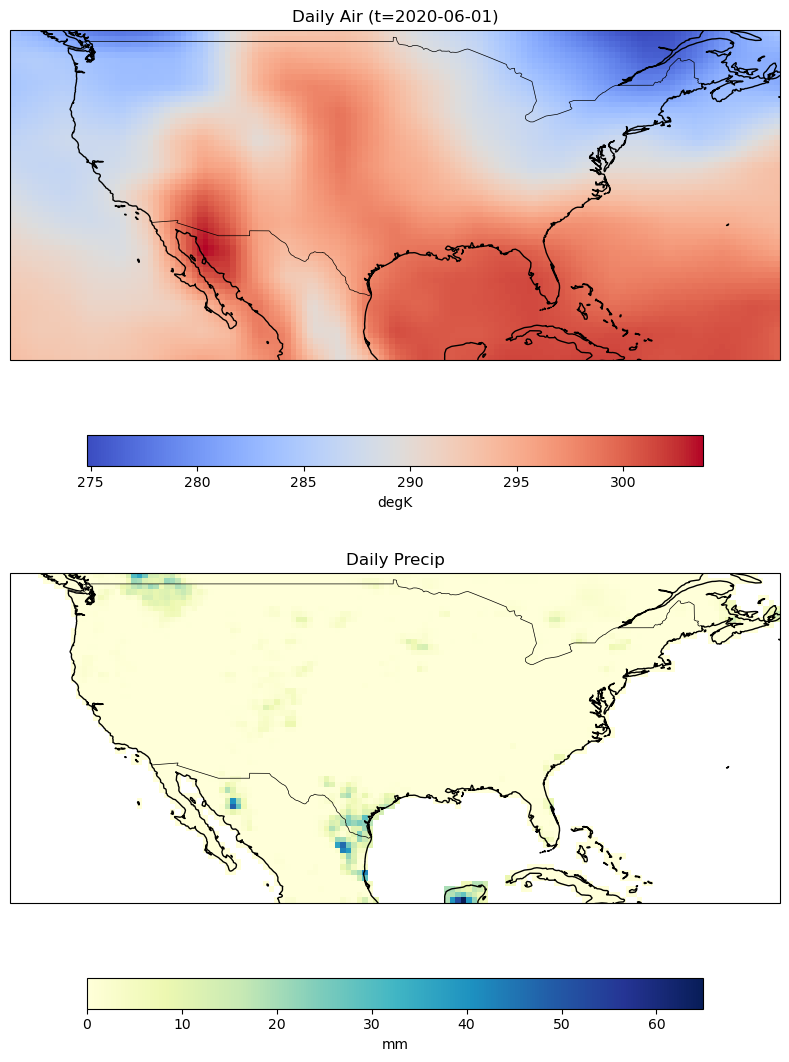

In [9]:
t0 = merged.isel(time=0)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 11))

ax1 = fig.add_subplot(2, 1, 1, projection=proj)
im1 = ax1.pcolormesh(t0.lon, t0.lat, t0.air_temperature, transform=proj, cmap="coolwarm")
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.set_title(f"Daily Air (t={np.datetime_as_string(t0.time.values, unit='D')})")
cb1 = plt.colorbar(im1, ax=ax1, shrink=0.8, orientation="horizontal")
cb1.set_label(merged.air_temperature.attrs.get("units", ""))

ax2 = fig.add_subplot(2, 1, 2, projection=proj)
im2 = ax2.pcolormesh(t0.lon, t0.lat, t0.daily_precip, transform=proj, cmap="YlGnBu")
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.set_title("Daily Precip")
cb2 = plt.colorbar(im2, ax=ax2, shrink=0.8, orientation="horizontal")
cb2.set_label(merged.daily_precip.attrs.get("units", ""))

plt.tight_layout()
plt.show()

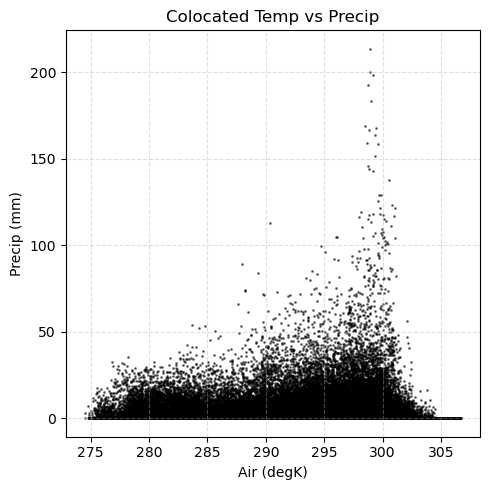

In [10]:
pair = merged[["air_temperature", "daily_precip"]].stack(sample=("lat", "lon")).dropna(dim="sample", how="any")

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pair["air_temperature"].values, pair["daily_precip"].values, s=1, alpha=0.5, c="black")
ax.set_xlabel(f"Air ({merged.air_temperature.attrs.get('units','')})")
ax.set_ylabel(f"Precip ({merged.daily_precip.attrs.get('units','')})")
ax.set_title("Colocated Temp vs Precip")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [11]:
merged.to_netcdf("air_precip_merged_daily.nc")